# Reconocimiento de Imágenes

## Importar librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense

In [3]:
from keras.datasets import fashion_mnist

In [4]:
import tensorflow as tf
from tensorflow import keras

In [5]:
import plotly.graph_objs as go
from plotly import subplots
from plotly.offline import iplot

In [6]:
from sklearn.model_selection import train_test_split 

In [8]:
from keras.layers import Dropout

## Semilla

In [9]:
np.random.seed(1)

## Importación de la Data

Tener en cuenta la descripción de la data [https://www.kaggle.com/zalando-research/fashionmnist](https://www.kaggle.com/zalando-research/fashionmnist)

In [10]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [11]:
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)


## Muestra randomica del dataset

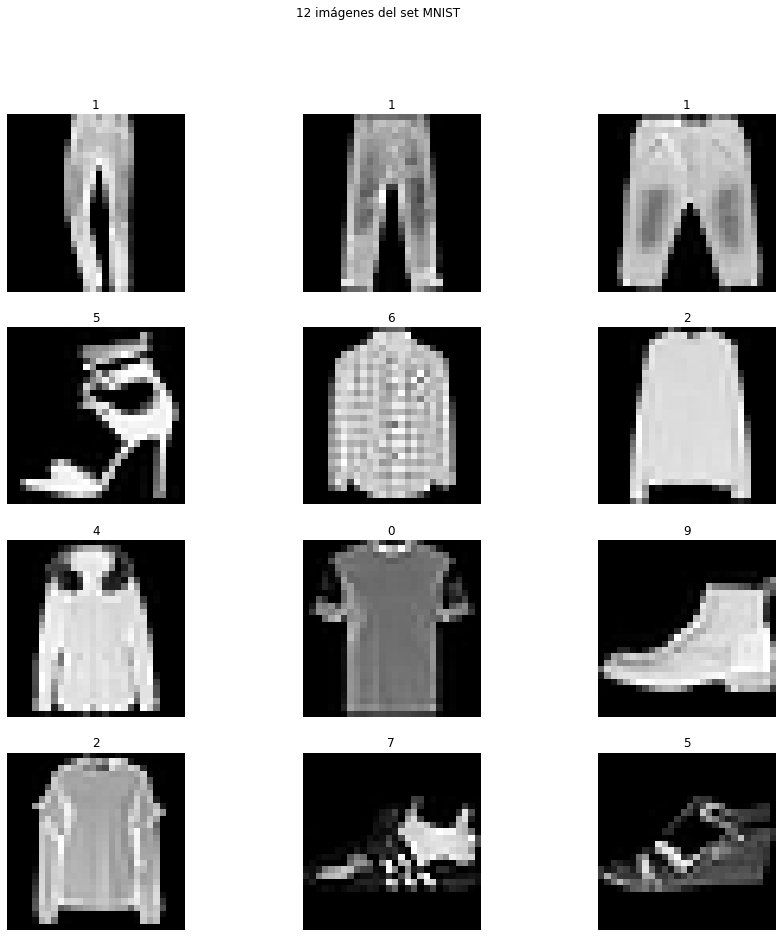

In [12]:
images = np.random.randint(0, x_train.shape[0], 12)
plt.figure(figsize=(15, 15))

for i in range(len(images)):
    img = x_train[images[i], : , :]
    plt.subplot(4, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(y_train[images[i]])
plt.suptitle('12 imágenes del set MNIST')
plt.show()

## Normalizar los datos

Los valores de los pixeles estan en un rango de [0, 255], pero se requiere que el rango este entre [0, 1], por tal razón se dividen los datos en 255. También se debe tener en cuenta que se cuenta con 10 categorias (del 0 al 9) las cuales se pueden presentar en un formato one-hot.

In [13]:
X_train = x_train/255.0
X_test = x_test/255.0

In [14]:
n_classes = 10

Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

### Normalizar los datos a una escala de grises

In [15]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

### Muestra aleatoria de los datos normalizados

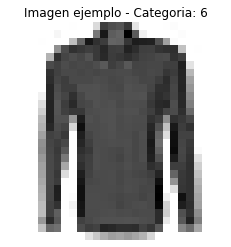

In [16]:
n_img = 40

plt.imshow(X_train[n_img, :].reshape(28, 28), cmap='gray_r')
plt.title('Imagen ejemplo - Categoria: ' + str(np.argmax(Y_train[n_img])))
plt.axis('off')
plt.show()

## Definir las gráficas y funciones post-entrenamiento

In [17]:
labels = ['val_accuracy', 'accuracy', 'loss', 'val_loss']

def iter_max_or_min_value(model, labels, fun = max):
    for label in labels:
        val = fun(model.history[label])
        lst = np.array(model.history[label])
        result = np.where(lst == val)
        print(label, result[0], val)

In [18]:
def last_value(model, labels):
    for i in labels:
        last = model.history[i].pop()
        print(i, last)

In [19]:
def simple_graph(model, labels):
    fig, ax = plt.subplots(figsize=(20, 15))
    index = 0

    for i in range(len(labels)):
        plt.subplot(2, 2, i+1)
        plt.plot(model.history[labels[i]])
        plt.title(f'{labels[i]} vs Iteraciones')
        plt.ylabel(f'{labels[i]}')
        plt.xlabel('Itereacion')

    plt.suptitle('Resultados del entrenamiento vs Iteraciones')

In [20]:
def create_trace(x, y, ylabel, color):
    trace = go.Scatter(
            x = x,
            y = y,
            name= ylabel,
            marker= dict(color=color),
            mode = "markers+lines",
            text = x
    )
    return trace

In [21]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1, len(acc)+1))
    
    trace_ta = create_trace(epochs, acc, "Training accuracy", "Green")
    trace_va = create_trace(epochs, val_acc, "Validation accuracy", "Red")
    trace_tl = create_trace(epochs, loss, "Training loss", "Blue")
    trace_vl = create_trace(epochs, val_loss, "Validation loss", "Magenta")
   
    fig = subplots.make_subplots(rows=1, cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta, 1, 1)
    fig.append_trace(trace_va, 1, 1)
    fig.append_trace(trace_tl, 1, 2)
    fig.append_trace(trace_vl, 1, 2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename='accuracy-loss')

## Construcción de la Red Neuronal Convulucional

El modelo `Sequential` es un pila lineal de capas. Este puede ser inicializada y luego añadir capas mediante el método de `add` o podemos añadir las capas y luego inicializar el modelo. Las capas añadidas son las siguientes: 

- `Conv2D` es una capa Convolucional 2D (es decir convulución espacial sobre imágenes). Los parámetros que usan son:
    - `filters`: el número de filtros o Kernels usados en esta capa, la primera capa aplicara 32.
    - `kernel_size`: La dimensión del Kernel (3 x 3)
    - `activation`: es la función de activación usada, en este caso `relu`
    - `kernel_initializer`: La función usada para inicializar el kernel.
    - `input_shape`: Es el tamaño de la imágen presentada para la CNN (Red Neuronal Convolucional), en nuestro caso es 28x28. La entrada y salida de `Conv2D` es un tensor 4D
- `MaxPooling2D` es una operación de máxima profundidad para la data espacial. Los párametros usados aquí son:
    - `pool_size`: En este caso (2, 2), lo que representa la escala de factores mediante los cuales se reduce la escala en ambas direcciones.
- `Conv2D` con los siguientes parámetros:
    - `filters`: 64
    - `kernel_size`: (3 x 3)
    - `activation`: `relu`
- `MaxPooling2D` con parámetros
    - `pool_size`: (2, 2)
- `Conv2D` con los siguientes parámetros:
    - `filters`: 128
    - `kernel_size`: (3 x 3)
    - `activation`: `relu`
- `Flatten`: Esta capa aplana la entrada. No afecta el tamaño del `batch` o lote. Esta capa es usada sin parámetros.
- `Dense`: Esta capa es una capa NN completamente conectada. Esta es usada con los siguientes parámetros.
    - `units`: Es es un entero positivo, con el significado: *Dimensionalidad del espacio de salida*, en este caso es 128.
    - `activation`: Función de activación `relu`.
- `Dense`: Esta es la capa final totalmente conectada. Es usada con los siguientes parámetros.
    - `units`: El número de clases, en este caso 10.
    - `activation`: `softmax`, para esta capa final se usa la activación `softmax` la cual es un estandard para clasificación de multiclases.

Para compilar el modelo, especificamos los siguientes parámetros.

- `optimizer`: Adam
- `loss`: `categorical_crossentropy`
- `metrics`: precisión

https://www.kaggle.com/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist#Model

In [22]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))

In [23]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [25]:
def model_fit(X, Y, XVal, YVal, epochs = 1000):
    model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    train_model = model.fit(X, Y, epochs=epochs, batch_size=128, verbose=2, validation_data=(XVal, YVal))
    return train_model

## Compilado y Entrenamiento #1



In [27]:
train_model_1 = model_fit(X_train, Y_train, X_train, Y_train)

Epoch 1/1000
469/469 - 7s - loss: 0.0250 - accuracy: 0.9914 - val_loss: 0.0176 - val_accuracy: 0.9941 - 7s/epoch - 16ms/step
Epoch 2/1000
469/469 - 7s - loss: 0.0218 - accuracy: 0.9923 - val_loss: 0.0322 - val_accuracy: 0.9891 - 7s/epoch - 14ms/step
Epoch 3/1000
469/469 - 7s - loss: 0.0209 - accuracy: 0.9923 - val_loss: 0.0110 - val_accuracy: 0.9962 - 7s/epoch - 14ms/step
Epoch 4/1000
469/469 - 7s - loss: 0.0172 - accuracy: 0.9942 - val_loss: 0.0204 - val_accuracy: 0.9925 - 7s/epoch - 14ms/step
Epoch 5/1000
469/469 - 6s - loss: 0.0210 - accuracy: 0.9925 - val_loss: 0.0126 - val_accuracy: 0.9957 - 6s/epoch - 13ms/step
Epoch 6/1000
469/469 - 6s - loss: 0.0192 - accuracy: 0.9935 - val_loss: 0.0108 - val_accuracy: 0.9965 - 6s/epoch - 13ms/step
Epoch 7/1000
469/469 - 6s - loss: 0.0181 - accuracy: 0.9937 - val_loss: 0.0218 - val_accuracy: 0.9923 - 6s/epoch - 13ms/step
Epoch 8/1000
469/469 - 6s - loss: 0.0216 - accuracy: 0.9925 - val_loss: 0.0132 - val_accuracy: 0.9955 - 6s/epoch - 13ms/step


## Gráficas del entrenamiento #1

In [28]:
print('Valores máximos en las iteracciones\n')
iter_max_or_min_value(train_model_1, labels)

print('\n\n\nValores minimos en las iteracciones\n')
iter_max_or_min_value(train_model_1, labels, min)

Valores máximos en las iteracciones

val_accuracy [532 809 964] 0.9998833537101746
accuracy [826] 0.999833345413208
loss [888] 0.033845264464616776
val_loss [905] 0.06093473359942436



Valores minimos en las iteracciones

val_accuracy [10] 0.9857333302497864
accuracy [0] 0.9914000034332275
loss [588] 0.0009856914402917027
val_loss [587] 0.0004680558922700584


In [29]:
print('Valores de la última iteracción\n')
last_value(train_model_1, labels)

Valores de la última iteracción

val_accuracy 0.9993333220481873
accuracy 0.9991999864578247
loss 0.008162531070411205
val_loss 0.00993125606328249


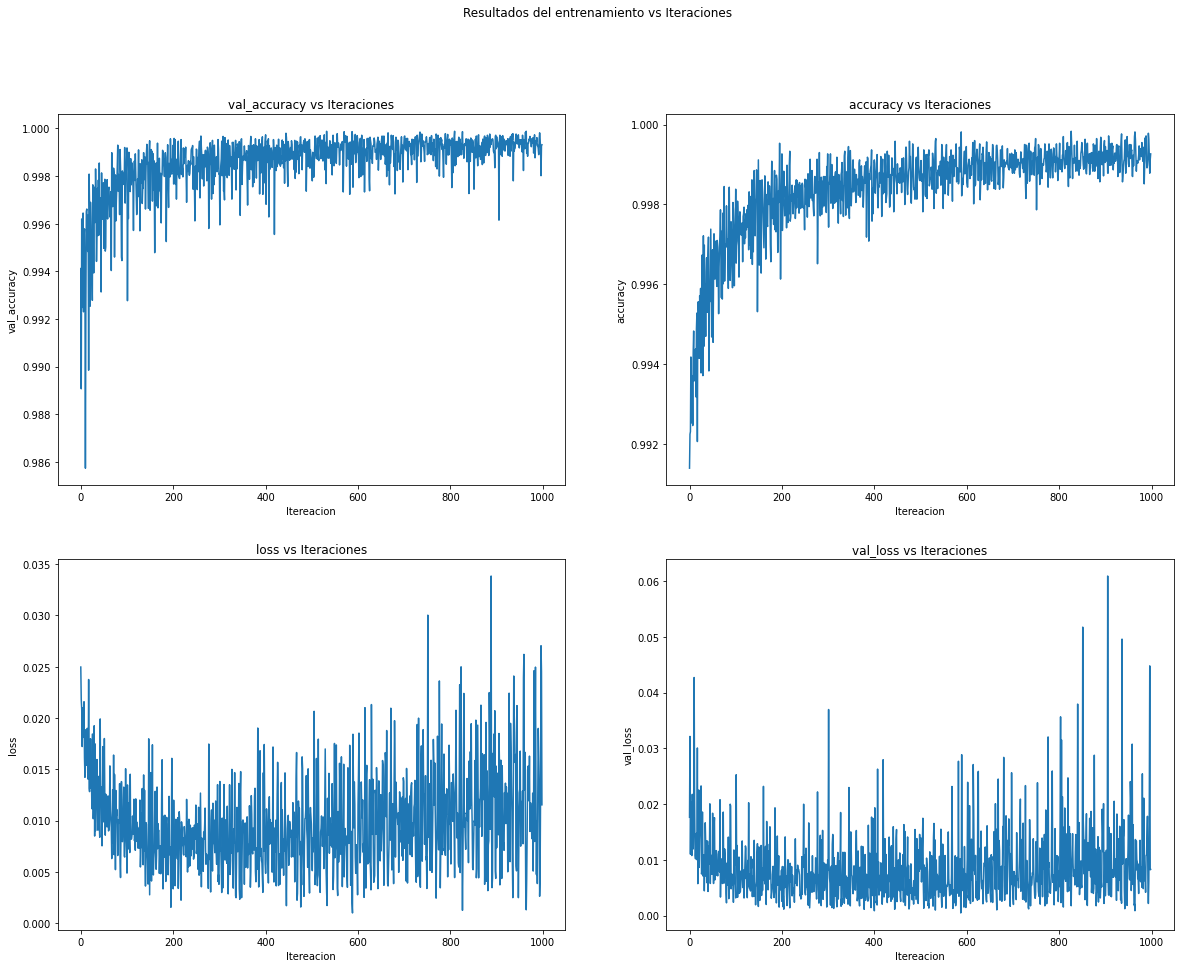

In [30]:
simple_graph(train_model_1, labels)

In [31]:
plot_accuracy_and_loss(train_model_1)

## Conclusiones del entrenamiento

Este modelo presenta una precisión y una valoración de la misma de más del 90%, para ser exactos: 

- val_accuracy 99.93%
- accuracy 99.91%

Además, los valores de la perdida y valoración de la perdida son de:

- loss 0.08%
- val_loss 0.09%


Puede que el modelo llegue a presentar un overfitting con respecto a los valores del dataset, por lo tanto se han planteado en las siguientes partes un separación randomica para los datos y una construcción de capas diferentes para el modelo. Al momento de la entrega, por limitantes del equipo, no se han podido hacer las ejecuciones de dichos modelos.

## Separa la data de entrenamiento en train y test

In [26]:
XTrain, XVal, YTrain, YVal = train_test_split(X_train, Y_train, test_size=0.8, random_state=42)

## Entrenamiento #2

In [ ]:
train_model_2 = model_fit(XTrain, YTrain, XVal, YVal)

Epoch 1/1000
94/94 - 21s - loss: 0.8074 - accuracy: 0.7076 - val_loss: 0.5471 - val_accuracy: 0.8037 - 21s/epoch - 223ms/step
Epoch 2/1000
94/94 - 20s - loss: 0.4957 - accuracy: 0.8193 - val_loss: 0.4631 - val_accuracy: 0.8290 - 20s/epoch - 209ms/step
Epoch 3/1000
94/94 - 20s - loss: 0.4112 - accuracy: 0.8506 - val_loss: 0.4256 - val_accuracy: 0.8429 - 20s/epoch - 209ms/step
Epoch 4/1000
94/94 - 20s - loss: 0.3560 - accuracy: 0.8716 - val_loss: 0.3871 - val_accuracy: 0.8597 - 20s/epoch - 208ms/step
Epoch 5/1000
94/94 - 20s - loss: 0.3198 - accuracy: 0.8864 - val_loss: 0.3621 - val_accuracy: 0.8677 - 20s/epoch - 209ms/step
Epoch 6/1000
94/94 - 20s - loss: 0.2867 - accuracy: 0.8957 - val_loss: 0.3468 - val_accuracy: 0.8754 - 20s/epoch - 209ms/step
Epoch 7/1000
94/94 - 20s - loss: 0.2635 - accuracy: 0.9033 - val_loss: 0.3464 - val_accuracy: 0.8768 - 20s/epoch - 209ms/step
Epoch 8/1000
94/94 - 20s - loss: 0.2399 - accuracy: 0.9135 - val_loss: 0.3601 - val_accuracy: 0.8763 - 20s/epoch - 209

## Gráficas del entrenamiento #2



In [ ]:
print('Valores máximos en las iteracciones\n')
iter_max_or_min_value(train_model_2, labels)

print('\n\n\nValores minimos en las iteracciones\n')
iter_max_or_min_value(train_model_2, labels, min)

In [ ]:
print('Valores de la última iteracción\n')
last_value(train_model_2, labels)

In [ ]:
simple_graph(train_model_2, labels)

In [ ]:
plot_accuracy_and_loss(train_model_2)

## Modelo con capas de Dropout o Exclusión al modelo

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.4))

In [ ]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(n_classes, activation='softmax'))

## Entrenamiento #3

In [ ]:
train_model_3 = model_fit(X_train, Y_train, X_train, Y_train)

## Gráficas del entrenamiento #3

In [ ]:
print('Valores máximos en las iteracciones\n')
iter_max_or_min_value(train_model_3, labels)

print('\n\n\nValores minimos en las iteracciones\n')
iter_max_or_min_value(train_model_3, labels, min)

In [ ]:
print('Valores de la última iteracción\n')
last_value(train_model_3, labels)

In [ ]:
simple_graph(train_model_3, labels)

In [ ]:
plot_accuracy_and_loss(train_model_3)

## Entrenamiento #4



In [ ]:
train_model_4 = model_fit(XTrain, YTrain, XVal, YVal)

## Gráficas del entrenamiento #3

In [ ]:
print('Valores máximos en las iteracciones\n')
iter_max_or_min_value(train_model_4, labels)

print('\n\n\nValores minimos en las iteracciones\n')
iter_max_or_min_value(train_model_4, labels, min)

In [ ]:
print('Valores de la última iteracción\n')
last_value(train_model_4, labels)

In [ ]:
simple_graph(train_model_4, labels)

In [ ]:
plot_accuracy_and_loss(train_model_4)

## Extras


In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(f'Precisión en el set de validación {100 * score[1]}')

Precisión en el set de validación 90.78999757766724


Precisión en el set de validación: 90.8%


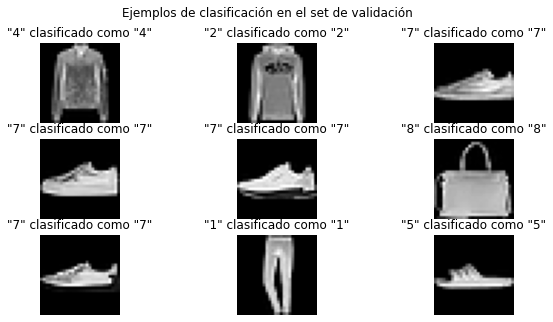

In [ ]:
puntaje = model.evaluate(X_test, Y_test, verbose=0)
print('Precisión en el set de validación: {:.1f}%'.format(100*puntaje[1]))
Y_pred = model.predict(X_test)
classes_y = np.argmax(Y_pred, axis=1)

plt.figure(figsize=(10,5))
imagenes = np.random.randint(0, X_test.shape[0],9)

for i in range(len(imagenes)):
	idx = imagenes[i]
	img = X_test[idx,:].reshape(28,28)
	cat_original = np.argmax(Y_test[idx,:])
	cat_prediccion = classes_y[idx]

	plt.subplot(3, 3, i+1)
	plt.imshow(img, cmap='gray')
	plt.axis('off')
	plt.title('"{}" clasificado como "{}"'.format(cat_original, cat_prediccion))
plt.suptitle('Ejemplos de clasificación en el set de validación')
plt.show()


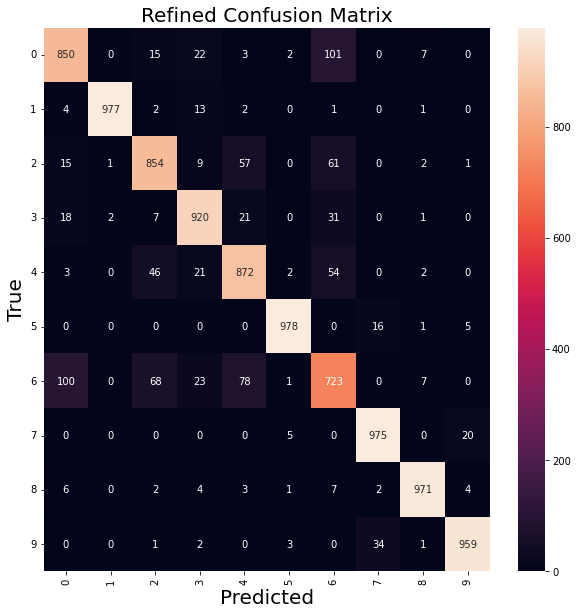

In [ ]:
#Matriz de confusión
import seaborn as sns
from sklearn.metrics import confusion_matrix
class_names = ['0','1','2','3','4','5','6','7','8','9']
#Y_pred = modelo.predict(X_test)
#classes_y=np.argmax(Y_pred,axis=1)
y_true = np.argmax(Y_test, axis=1)

cm = confusion_matrix(y_true, classes_y)

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(10, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

Counter({9: 1000, 2: 1000, 1: 1000, 6: 1000, 4: 1000, 5: 1000, 7: 1000, 3: 1000, 8: 1000, 0: 1000})
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


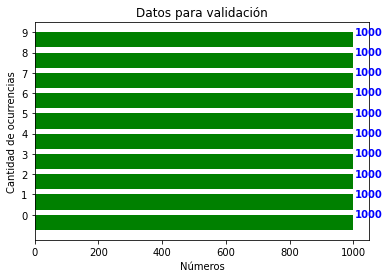

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

df = pd.DataFrame(y_test, columns = ['Número'])
conteo = Counter(y_test)
conteo_ordenado = [0 for i in range(10)]
print(conteo)

for num, cont in conteo.items():
  conteo_ordenado[num] = cont 
print(conteo_ordenado)

fig, ax = plt.subplots() 
ind = np.arange(len(conteo_ordenado))   # ubicaciones de los grupos
width = 0.75                            # ancho de la barra
ax.barh(ind, conteo_ordenado, width, color = "green") 

ax.set_yticks(ind+width/2)  
ax.set_yticklabels(class_names, minor=False)
plt.ylabel('Cantidad de ocurrencias')
plt.xlabel('Números')
plt.title('Datos para validación')
for i, v in enumerate(conteo_ordenado):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
plt.show()